# Lab 3: Training Decision Tree & KNN Classifiers

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None 


from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In this Lab session, you will implement the following steps:

1. Load the Airbnb "listings" data set
2. Convert categorical features to one-hot encoded values
3. Split the data into training and test sets
4. Fit a Decision Tree classifier and evaluate the accuracy
 - Plot the accuracy of the DT model as a function of hyperparameter max depth
5. Fit a KNN classifier and evaluate the accuracy
 - Plot the accuracy of the KNN model as a function of hyperparameter $k$

## Part 1. Load the Dataset

We will work with a pre-processed version of the Airbnb NYC "listings" data set.

<b>Task</b>: load the data set into a Pandas DataFrame variable named `df`:

In [2]:
# Do not remove or edit the line below:
filename = os.path.join(os.getcwd(), "data", "airbnb.csv.gz")

df = pd.read_csv(filename, header = 0)

In [3]:
df.shape

(28022, 44)

In [4]:
df.head(10)

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,room_type,accommodates,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,n_host_verifications
0,0.800000,0.170000,False,8.0,8.0,True,True,Manhattan,Entire home/apt,1,...,4.79,4.86,4.41,False,3,3,0,0,0.33,9
1,0.090000,0.690000,False,1.0,1.0,True,True,Brooklyn,Entire home/apt,3,...,4.80,4.71,4.64,False,1,1,0,0,4.86,6
2,1.000000,0.250000,False,1.0,1.0,True,True,Brooklyn,Entire home/apt,4,...,5.00,4.50,5.00,False,1,1,0,0,0.02,3
3,1.000000,1.000000,False,1.0,1.0,True,False,Manhattan,Private room,2,...,4.42,4.87,4.36,False,1,0,1,0,3.68,4
4,0.890731,0.768297,False,1.0,1.0,True,True,Manhattan,Private room,1,...,4.95,4.94,4.92,False,1,0,1,0,0.87,7
5,1.000000,1.000000,True,3.0,3.0,True,True,Brooklyn,Private room,2,...,4.82,4.87,4.73,False,3,1,2,0,1.48,7
6,1.000000,1.000000,False,1.0,1.0,True,True,Brooklyn,Entire home/apt,3,...,4.80,4.67,4.57,True,1,1,0,0,1.24,7
7,1.000000,1.000000,False,3.0,3.0,True,True,Manhattan,Private room,1,...,4.95,4.84,4.84,True,1,0,1,0,1.82,5
8,1.000000,0.000000,False,2.0,2.0,True,True,Brooklyn,Private room,1,...,5.00,5.00,5.00,False,2,0,2,0,0.07,5
9,1.000000,0.990000,True,1.0,1.0,True,True,Brooklyn,Entire home/apt,4,...,4.91,4.93,4.78,True,2,1,1,0,3.05,8


In [5]:
df.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_coun

## Part 2. One-Hot Encode Categorical Values


Transform the string-valued categorical features into numerical boolean values using one-hot encoding.

### a. Find the Columns Containing String Values

First, let us identify all features that need to be one-hot encoded:

In [6]:
df.dtypes

host_response_rate                              float64
host_acceptance_rate                            float64
host_is_superhost                                  bool
host_listings_count                             float64
host_total_listings_count                       float64
host_has_profile_pic                               bool
host_identity_verified                             bool
neighbourhood_group_cleansed                     object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bedrooms                                        float64
beds                                            float64
amenities                                        object
price                                           float64
minimum_nights                                    int64
maximum_nights                                    int64
minimum_minimum_nights                          

**Task**: add all of the column names of variables of type 'object' to a list named `to_encode`

In [7]:
to_encode = list(df.select_dtypes(include = ['object']).columns)

Let's take a closer look at the candidates for one-hot encoding

In [8]:
df[to_encode].nunique()

neighbourhood_group_cleansed        5
room_type                           4
amenities                       25020
dtype: int64

Notice that one column stands out as containing two many values for us to attempt to transform. For this exercise, the best choise is to simply remove this column. Of course, this means losing potentially useful information. In a real-life situation, you would want to retain all of the information in a column, or you could selectively keep information in.

In the code cell below, drop this column from Dataframe `df` and from the `to_encode` list.

In [9]:
df.drop(columns = ['amenities'], inplace = True)
to_encode.remove('amenities')

### b. One-Hot Encode all Unique Values

All of the other columns in `to_encode` have reasonably small numbers of unique values, so we are going to simply one-hot encode every unique value of those columns.

<b>Task</b>: complete the code below to create one-hot encoded columns
Tip: Use the sklearn `OneHotEncoder` class

In [10]:
from sklearn.preprocessing import OneHotEncoder

# Create the encoder:
encoder = OneHotEncoder(handle_unknown="error", sparse=False)

# Apply the encoder:
df_enc = pd.DataFrame(encoder.fit_transform(df[to_encode]))

# Reinstate the original column names:
df_enc.columns = encoder.get_feature_names(to_encode)

In [11]:
df_enc.head()

,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<b>Task</b>: You can now remove the original columns that we have just transformed from DataFrame `df`.


In [12]:
df.drop(columns = to_encode ,axis=1, inplace=True)


In [13]:
df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,n_host_verifications
0,0.800000,0.170000,False,8.0,8.0,True,True,1,1.0,1.323567,...,4.79,4.86,4.41,False,3,3,0,0,0.33,9
1,0.090000,0.690000,False,1.0,1.0,True,True,3,1.0,1.000000,...,4.80,4.71,4.64,False,1,1,0,0,4.86,6
2,1.000000,0.250000,False,1.0,1.0,True,True,4,1.5,2.000000,...,5.00,4.50,5.00,False,1,1,0,0,0.02,3
3,1.000000,1.000000,False,1.0,1.0,True,False,2,1.0,1.000000,...,4.42,4.87,4.36,False,1,0,1,0,3.68,4
4,0.890731,0.768297,False,1.0,1.0,True,True,1,1.0,1.000000,...,4.95,4.94,4.92,False,1,0,1,0,0.87,7


<b>Task</b>: You can now join the transformed categorical features contained in `df_enc` with DataFrame `df`

In [14]:
df = df.join(df_enc)

Glance at the resulting column names:

In [15]:
df.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_r

Check for missing values.

In [16]:
pd.isnull(df).values.any()

False

## Part 3. Create Training and Test Data Sets

### a. Create Labeled Examples 

<b>Task</b>: Choose columns from our data set to create labeled examples. 

In the `airbnb` dataset, we will choose column `host_is_superhost` to be the label. The remaining columns will be the features.

Obtain the features from DataFrame `df` and assign to `X`.
Obtain the label from DataFrame `df` and assign to `Y`


In [27]:
X = df.drop(columns = 'host_is_superhost', axis = 1)
y = df['host_is_superhost']

In [28]:
print("Number of examples: " + str(X.shape[0]))
print("\nNumber of Features:" + str(X.shape[1]))
print(str(list(X.columns)))

Number of examples: 28022

Number of Features:49
['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'n_host_

### b. Split Examples into Training and Test Sets

<b>Task</b>: In the code cell below create training and test sets out of the labeled examples using Scikit-learn's `train_test_split()` function. 

Specify:
    * A test set that is one third (.33) of the size of the data set.
    * A seed value of '123'. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 123)

Check that the dimensions of the training and test datasets are what you expected

In [30]:
print(X_train.shape)
print(X_test.shape)

(18774, 49)
(9248, 49)


## Part 4. Implement a Decision Tree Classifier

The code cell below contains a shell of a function named `train_test_DT()`. This function should train a Decision Tree classifier on the training data, test the resulting model on the test data, and compute and return the accuracy score of the resulting predicted class labels on the test data. Remember to use ```DecisionTreeClassifier()``` to create a model object.

<b>Task:</b> Complete the function to make it work.

In [31]:
def train_test_DT(X_train, X_test, y_train, y_test, leaf, depth, crit='entropy'):
    '''
    Fit a Decision Tree classifier to the training data X_train, y_train.
    Return the accuracy of resulting predictions on the test set.
    Parameters:
        leaf := The minimum number of samples required to be at a leaf node 
        depth := The maximum depth of the tree
        crit := The function to be used to measure the quality of a split. Default: gini.
    '''
    
    model = DecisionTreeClassifier(criterion = crit, max_depth = depth, min_samples_leaf = leaf)
    model.fit(X_train, y_train)
    class_label_predictions = model.predict(X_test)
    acc_score = accuracy_score(y_test, class_label_predictions)
    return acc_score

#### Visualization

The cell below contains a function that you will use to compare the accuracy results of training multiple models with different hyperparameter values.

Function `visualize_accuracy()` accepts two arguments:
1. a list of hyperparamter values
2. a list of accuracy scores

Both lists must be of the same size.

In [32]:
# Do not remove or edit the code below

def visualize_accuracy(hyperparam_range, acc):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    p = sns.lineplot(x=hyperparam_range, y=acc, marker='o', label = 'Full training set')
        
    plt.title('Test set accuracy of the model predictions, for ' + ','.join([str(h) for h in hyperparam_range]))
    ax.set_xlabel('Hyperparameter value')
    ax.set_ylabel('Accuracy')
    plt.show()

#### Train on Different Values of Hyperparameter Max Depth

<b>Task:</b> 

Complete function `train_multiple_trees()` in the code cell below. The function should train multiple decision trees and return a list of accuracy scores.

The function will:

1. accept list `max_depth_range` and `leaf` as parameters; list `max_depth_range` will contain multiple values for hyperparameter max depth.

2. loop over list `max_depth_range` and at each iteration:

    a. index into list `max_depth_range` to obtain a value for max depth<br>
    b. call `train_test_DT` with the training and test set, the value of max depth, and the value of `leaf`<br>
    c. print the resulting accuracy score<br>
    d. append the accuracy score to list `accuracy_list`<br>


In [33]:
def train_multiple_trees(max_depth_range, leaf):
    
    accuracy_list = []
    for md in max_depth_range:
        score = train_test_DT(X_train, X_test, y_train, y_test, leaf, md)
        print('Max Depth=' + str(md) + ', accuracy score: ' + str(score))
        accuracy_list.append(float(score))
    
    return accuracy_list

The code cell below tests function `train_multiple_trees()` and calls function `visualize_accuracy()` to visualize the results.

Max Depth=8, accuracy score: 0.8332612456747405
Max Depth=32, accuracy score: 0.8050389273356401


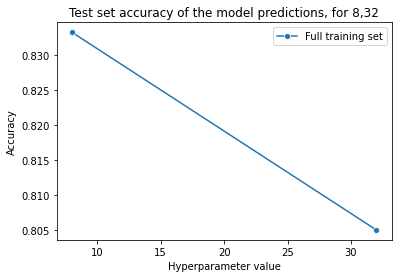

In [34]:
max_depth_range = [8, 32]
leaf = 1

acc = train_multiple_trees(max_depth_range, leaf)

visualize_accuracy(max_depth_range, acc)

<b>Analysis</b>: Is this graph conclusive for determining a good value of max depth?

<Double click this Markdown cell to make it editable, and record your findings here.>
This graph isn't conclusive for determining a good value of max depth because it tests the algorithm's accuracy with only two different values of max depth. In addition, one value is much larger than the other, so there may be a value in between the two that is an optimal max depth since higher max depth values lead to greater complexity and overfitting while lower values lead to low complexity and underfitting. The accuracy scores associated with a larger number of max depth values will be more conclusive and allow us to determine a more optimal value of max depth. 

<b>Task:</b> Let's train on more values for max depth.

In the code cell below:

1. call `train_multiple_trees()` with arguments `max_depth_range` and `leaf`
2. call `visualize_accuracy()` with arguments `max_depth_range` and `acc`


Max Depth=1, accuracy score: 0.7563797577854672
Max Depth=2, accuracy score: 0.7563797577854672
Max Depth=4, accuracy score: 0.810878027681661
Max Depth=8, accuracy score: 0.8339100346020761
Max Depth=16, accuracy score: 0.8131487889273357
Max Depth=32, accuracy score: 0.8030925605536332


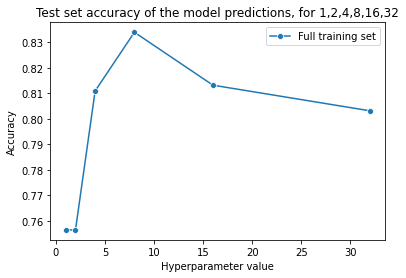

In [35]:
max_depth_range = [2**i for i in range(6)]
leaf = 1
acc = train_multiple_trees(max_depth_range, leaf)
        
visualize_accuracy(max_depth_range, acc)  

<b>Analysis</b>: Analyze this graph. Keep in mind that this is the performance on the test set, and pay attention to the scale of the y-axis. Answer the following questions in the cell below.<br>
How would you go about choosing the best model based on this plot? Is it conclusive? <br>
How would you establish whether your model, for a given value of `max_depth`, is overfitting to the data? <br>
What other hyperparameters of interest would you want to vary to make sure you are finding the best model fit?

<Double click this Markdown cell to make it editable, and record your answers here.>
Based on this plot, the best model would have a max depth of 8 because that is when the accuracy score is the greatest, compared to the 5 other accuracy scores. This plot is conclusive since it tests max depth values that are spaced out and the plot displays a peak, which reveals an optimal max depth value that results in the largest accuracy. The peak or the optimal max depth value is the value at which the model will not be overfitting or underfitting. As the max depth value becomes larger than 8, the accuracy score of the model decreases because the model is becoming too complex and overfitting. You would also want to vary min_sample_split and min_samples_leaf to make sure you are finding the best model fit. 

## Part 5. Implement a KNN Classifier


Note: In this section you will train KNN Classifiers using the same training and test data.

The code cell below contains a shell of a function named `train_test_knn()`. This function should train a KNN classifier on the training data, test the resulting model on the test data, and compute and return the accuracy score of the resulting predicted class labels on the test data. 

Remember to use ```KNeighborsClassifier()``` to create a model object and call the method with one parameter: `n_neighbors = k`. 

<b>Task:</b> Complete the function to make it work.

In [36]:
def train_test_knn(X_train, X_test, y_train, y_test, k):
    '''
    Fit a k Nearest Neighbors classifier to the training data X_train, y_train.
    Return the accuracy of resulting predictions on the test data.
    '''
    
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    class_label_predictions = model.predict(X_test)
    acc_score = accuracy_score(y_test, class_label_predictions)
    return acc_score

#### Train on Different Values of Hyperparameter K

<b>Task:</b> 

Just as you did above, complete function `train_multiple_knns()` in the code cell below. The function should train multiple KNN models and return a list of accuracy scores.

The function will:

1. accept list `k_range` as a parameter; this list will contain multiple values for hyperparameter $k$

2. loop over list `k_range` and at each iteration:

    a. index into list `k_range` to obtain a value for $k$<br>
    b. call `train_test_knn` with the training and test set, and the value of $k$<br>
    c. print the resulting accuracy score<br>
    d. append the accuracy score to list `accuracy_list` <br>


In [37]:
def train_multiple_knns(k_range):
    
    accuracy_list = []

    for k in k_range:
        score = train_test_knn(X_train, X_test, y_train, y_test, k)
        print('k=' + str(k) + ', accuracy score: ' + str(score))
        accuracy_list.append(float(score))
    
    return accuracy_list

The code cell below uses your `train_multiple_knn()` function to train 3 KNN models, specifying three values for $k$: $3, 30$, and $300$. It calls function `visualize_accuracy()` to visualize the results. Note: this make take a second.

k=3, accuracy score: 0.759515570934256
k=30, accuracy score: 0.7755190311418685
k=300, accuracy score: 0.7696799307958477


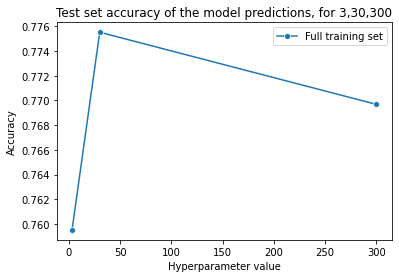

In [38]:
k_range = [3, 30, 300]
acc = train_multiple_knns(k_range)

visualize_accuracy(k_range, acc)

<b>Task:</b> Let's train on more than values for $k$

In the code cell below:

1. call `train_multiple_knns()` with argument `k_range`
2. call `visualize_accuracy()` with arguments `k_range` and the resulting accuracy list obtained from `train_multiple_knns()`


k=1, accuracy score: 0.7454584775086506
k=4, accuracy score: 0.77530276816609
k=7, accuracy score: 0.7654628027681661
k=10, accuracy score: 0.7743295847750865
k=13, accuracy score: 0.7730320069204152
k=16, accuracy score: 0.7763840830449827
k=19, accuracy score: 0.7754108996539792
k=22, accuracy score: 0.776924740484429
k=25, accuracy score: 0.77530276816609
k=28, accuracy score: 0.7741133217993079
k=31, accuracy score: 0.7756271626297578
k=34, accuracy score: 0.7763840830449827
k=37, accuracy score: 0.7749783737024222


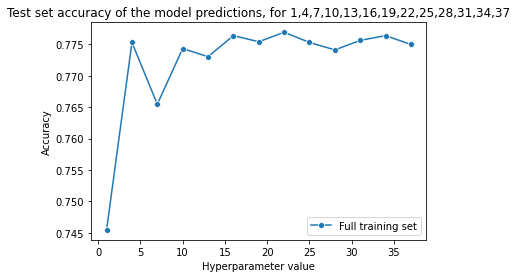

In [39]:
k_range = np.arange(1, 40, step = 3) 

acc = train_multiple_knns(k_range)
visualize_accuracy(k_range, acc)

<b>Analysis</b>: Compare the performance of the KNN model relative to the Decision Tree model, with various hyperparameter values and record your findings in the cell below.

<Double click this Markdown cell to make it editable, and record your findings here.>
The Decision Tree model had a peak accuracy score when the max depth was set at an optimal value that did not cause overfitting or underfitting. This peak was found when the accuracy scores associated with various max depth values, that were evenly spaced out, were plotted. However, a peak accuracy score is apparent for the KNN model with a smaller variety of values for k. When k is set to a larger variety of numbers, there are many alternating patterns of high and low accuracy scores for the KNN model. However, it's important to note that these patterns are due to the scaling of the y axis and that the accuracy scores for the KNN model is very similar for various k values. The accuracy scores for the Decision Tree model is not so similar for various max depth values. While the accuracy score of the Decision Tree model is sensitive to a change in the hyperparameter value, the accuracy score of the KNN model is not so sensitive to a change in the hyperparameter value. Therefore, KNN is more stable regardless of its hyperparameter value.   